In [2]:
import numpy as np
import dill
import pandas as pd
from scipy import optimize as opt
import time
import sys
sys.path.append('../../')
import src


#Load policy and value function
#####################
#file_n = "2018-10-5vfi_dict.dill" #Personal Macbook
file_n = "2019-2-16vfi_dict.dill" #Work Macbook
with open('../../data/' + file_n, 'rb') as file:
    data_d = dill.load(file)

lambdas = src.generate_simplex_3dims(n_per_dim=data_d['n_of_lambdas_per_dim'])
price_grid = np.linspace(data_d['min_price'], data_d['max_price'])

policy = data_d['policy']
valueF = data_d['valueF']
lambdas_ext = src.generate_simplex_3dims(n_per_dim=
                                         data_d['n_of_lambdas_per_dim'])

#Interpolate policy (level price). valueF is already a function
policyF = src.interpolate_wguess(lambdas_ext, policy)


In [52]:
# Simulation parameters \
########################
σerror= 0.005 #0.01
Nfirms = 300
time_periods = 40
min_periods= 3

#Suitable for logistic
β10, β11 = -2, 3.5
β20, β21 = 1.3, -2.
betas = [β10, β11, β20, β21]

#GMM parameters
maxiters = 120

def lambda_0(x, prior_shock) -> np.ndarray:
    """
    Generate a vector of lambdas on the observables x
    """
    return src.from_theta_to_lambda0(x, θ=betas, prior_shock=prior_shock)


xs = np.abs(np.random.normal(0, 0.18, size=Nfirms))
prior_shocks = src.gen_prior_shocks(Nfirms, σerror=σerror)


dmd_shocks = src.generate_dmd_shocks(n=Nfirms, t=time_periods, dmd_σϵ=src.const.σ_ɛ)

df = src.simulate_all_firms(Nfirms, valueF, policyF, xs, θ=betas,
                            dmd_shocks=dmd_shocks, prior_shocks=prior_shocks)

std_devs = (df.groupby('firm').level_prices.rolling(window=4, min=3)
            .std().reset_index()
            .rename(columns={'level_1': 't',
                            'level_prices': 'std_dev_prices'}))

df = pd.merge(df, std_devs, on=['firm', 't'], how='left')

mean_std_observed_prices = df.groupby('t').std_dev_prices.mean()[min_periods:]

../../src/from_parameters_to_lambdas.py:9: RuntimeWarning: invalid value encountered in log
  return -np.sum(p+eps * np.log(p+eps))


In [53]:
def error_w_data(θ) -> float:
    return src.gmm_error(θ, policyF, xs,
                      mean_std_observed_prices=mean_std_observed_prices, df=df,
                                 prior_shocks=prior_shocks, min_periods=min_periods)

start = time.time()

optimi = opt.differential_evolution(error_w_data, [(-2.5, 0.5), (2.5, 4.0),
                                                   (0.5, 2), (-3., 1.)],
                                    maxiter=maxiters)

time_taken = time.time()/60 - start/60
print("Taken {0} minutes for {1} iterations. {2} per iteration".format(
      time_taken, maxiters, time_taken/maxiters))

../../src/from_parameters_to_lambdas.py:9: RuntimeWarning: invalid value encountered in log
  return -np.sum(p+eps * np.log(p+eps))
../../src/from_parameters_to_lambdas.py:47: RuntimeWarning: invalid value encountered in log
  block = np.log((1 - np.e ** (x[0] + x[1])) / (np.e ** (x[0]) + np.e ** (x[1]) + np.e ** (x[0] + x[1]) + 1))
../../src/from_parameters_to_lambdas.py:50: RuntimeWarning: divide by zero encountered in log
  num1 = (-np.log(np.e ** x[1] / (np.e ** x[1] + 1)) + block) * np.e ** x[1]
../../src/from_parameters_to_lambdas.py:50: RuntimeWarning: invalid value encountered in double_scalars
  num1 = (-np.log(np.e ** x[1] / (np.e ** x[1] + 1)) + block) * np.e ** x[1]
../../src/from_parameters_to_lambdas.py:57: RuntimeWarning: overflow encountered in double_scalars
  deb_1 = ((βs[1] - βs[2]) * np.e ** (-x[1])) / (1 + np.e ** (-x[1])) ** 2
../../src/from_parameters_to_lambdas.py:57: RuntimeWarning: invalid value encountered in double_scalars
  deb_1 = ((βs[1] - βs[2]) * np.e *

Taken 411.93133084848523 minutes for 120 iterations. 3.4327610904040435 per iteration


In [61]:
print("Success: ", optimi.success)
print("Valores reales: ", betas)
print("Optimizados: ", np.round(optimi.x, 2))
print("Errores porcentuales (de 1 a 100%): ", 
      np.round(200*(np.array(betas) - optimi.x)/(np.array(betas) + optimi.x), 2))

Success:  False
Valores reales:  [-2, 3.5, 1.3, -2.0]
Optimizados:  [-1.93  3.14  1.3  -1.98]
Errores porcentuales (de 1 a 100%):  [ 3.71 10.74  0.04  0.78]


In [50]:
betas

[-2, 3.5, 1.3, -2.0]

In [49]:
ind=88
realH = np.e**((betas[0] + betas[1]*xs[ind]))
realEβ = -np.e**(betas[2] + betas[3]*xs[ind])

estH = np.e**((optimi.x[0] + optimi.x[1]*xs[ind]))
estEβ = -np.e**(optimi.x[2] + optimi.x[3]*xs[ind])

print("H real y H estimado: ", realH, estH)
print("EB real y EB estimado: ", estH, estEβ)

H real y H estimado:  0.1574993777935831 0.6782823954210884
EB real y EB estimado:  0.6782823954210884 -4.241322894543044


In [51]:
optimi.x

array([-0.55982902,  3.9608758 ,  1.55273699, -2.48912488])

In [21]:
from scipy import optimize
from src import logit, jac, fun, force_sum_to_1, reparam_lambdas

def jac_(x):
    return jac(x, βs=src.betas_transition)



def from_theta_to_lambda0(x, θ, prior_shock, starting_values=np.array([0.1, 0.5])):
    """
    Generates a lambda0 vector from the theta vector and x
    It passes through the entropy and expected value of betas (H, EB)

    θ = [θ10, θ11, θ20, θ21]
    x : characteristics of firms
    prior_shock: puts randomness in the relationship between theta and lambda
    """
    #TODO: bound H between 0 and log(cardinality(lambdas))
    H = np.e**((θ[0] + θ[1]*x + prior_shock))
    Eβ = -np.e**(θ[2] + θ[3]*x + prior_shock) #Bound it?

    def fun_(x):
        return fun(x, src.betas_transition, Eβ, H)

    #Numerical procedure to get lambda vector from H, Eβ
    sol = optimize.root(fun_, logit(starting_values), jac=jac_)

    lambdas_sol = force_sum_to_1(reparam_lambdas(sol.x))

    return lambdas_sol

In [25]:
src.betas_transition

array([-4. , -1.7, -1.2])

In [43]:
betas

[-2, 3.5, 1.3, -2.0]

Text(0.5,1,'Eβ')

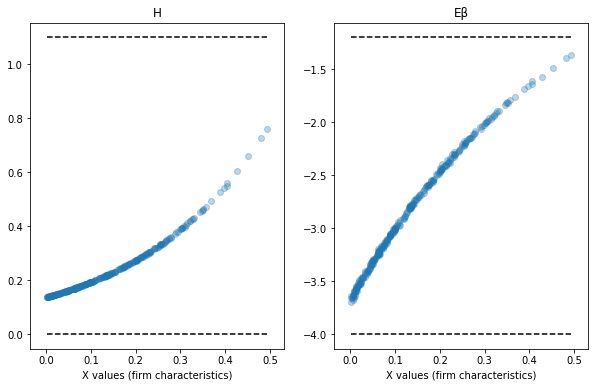

In [12]:
import matplotlib
#matplotlib.style.use('fivethirtyeight')
#Scatter plot of H, EB as function of x and prior_shocks

%matplotlib inline
import matplotlib.pyplot as plt

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 6), sharex=True)
θ = np.array([-2, 3.5, 1.3, -2.]) 

ax1.set_xlabel("X values (firm characteristics)")
ax2.set_xlabel("X values (firm characteristics)")
H = np.e**((θ[0] + θ[1]*xs + prior_shocks))
Eβ = -np.e**(θ[2] + θ[3]*xs + prior_shocks)
ax1.scatter(xs, H, alpha=0.3)
ax1.set_title("H")
ax1.hlines(0., xs.min(), xs.max(), linestyles="dashed")
ax1.hlines(np.log(3), xs.min(), xs.max(), linestyles="dashed")
ax2.scatter(xs, Eβ, alpha=0.3)
ax2.hlines(src.betas_transition.min(), xs.min(), xs.max(), linestyles="dashed")
ax2.hlines(src.betas_transition.max(), xs.min(), xs.max(), linestyles="dashed")
ax2.set_title("Eβ")


In [61]:
θ = np.array([-2, 3.5, 1.3, -2.]) 
θ_ = θ + 0.1
from_theta_to_lambda0(0.3, θ=θ_, prior_shock=prior_shocks[3])

../../src/from_parameters_to_lambdas.py:8: RuntimeWarning: invalid value encountered in log
  return -np.sum(p * np.log(p))


array([0.1, 0.5, 0.4])

In [43]:
src.betas_transition

array([-4. , -1.7, -1.2])

In [38]:
def my_entropy(p):
    return -np.sum(p * np.log(p))

In [46]:
my_entropy([1. - 0.00001, 0.00001, 0.00001])

0.0002402584592991924

In [ ]:
import numpy as np
import dill
import pandas as pd
from scipy import optimize as opt
import time
import sys
sys.path.append('../')
import src


#Load policy and value function
#####################
file_n = "2018-10-5vfi_dict.dill"
with open('../data/' + file_n, 'rb') as file:
    data_d = dill.load(file)

lambdas = src.generate_simplex_3dims(n_per_dim=data_d['n_of_lambdas_per_dim'])
price_grid = np.linspace(data_d['min_price'], data_d['max_price'])

policy = data_d['policy']
valueF = data_d['valueF']
lambdas_ext = src.generate_simplex_3dims(n_per_dim=
                                         data_d['n_of_lambdas_per_dim'])

#Interpolate policy (level price). valueF is already a function
policyF = src.interpolate_wguess(lambdas_ext, policy)


# Simulation parameters \
########################
σerror= 0.005 #0.01
Nfirms = 300
time_periods = 40
min_periods= 3

#Suitable for logistic
β10, β11 = -2, 3.5
β20, β21 = 1.3, -2.
betas = [β10, β11, β20, β21]

#GMM parameters
maxiters = 3


def lambda_0(x, prior_shock) -> np.ndarray:
    """
    Generate a vector of lambdas on the observables x
    """
    return src.from_theta_to_lambda0(x, θ=betas, prior_shock=prior_shock)


xs = np.abs(np.random.normal(0, 0.18, size=Nfirms))
prior_shocks = src.gen_prior_shocks(Nfirms, σerror=σerror)


dmd_shocks = src.generate_dmd_shocks(n=Nfirms, t=time_periods, dmd_σϵ=src.const.σ_ɛ)

df = src.simulate_all_firms(Nfirms, valueF, policyF, xs, θ=betas,
                            dmd_shocks=dmd_shocks, prior_shocks=prior_shocks)